In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk
import os
import collections
import re
import string

import preprocessor as p
import ktrain
from ktrain import text
import nltk
from sklearn.preprocessing import LabelEncoder


In [6]:
df = pd.read_csv("preprocess_data.csv",index_col=0)
df= df.dropna()
df.head()

,Unnamed: 0.1,_id,text,task_1,task_2,text_clean
0,4986,60c5d6bf5659ea5e55defa2c,@wealth if you made it through this &amp;&amp;...,HOF,PRFN,made amp amp onli abl start make money sustain...
1,3394,60c5d6bf5659ea5e55def461,Technically that's still turning back the cloc...,HOF,OFFN,technic still turn back clock dick head
2,1310,60c5d6bf5659ea5e55defaad,@VMBJP @BJP4Bengal @BJP4India @narendramodi @J...,NOT,NONE,govt stop think world media liber gang ani opt...
3,3390,60c5d6bf5659ea5e55def419,@krtoprak_yigit Soldier of Japan Who has dick ...,HOF,OFFN,soldier japan dick head
4,4626,60c5d6bf5659ea5e55def7fa,@blueheartedly You'd be better off asking who ...,HOF,OFFN,would better ask think sleazi shitbag lmao


In [7]:
LE = LabelEncoder()
LE.fit(df['task_2'])
classes= list(LE.classes_)
classes

['HATE', 'NONE', 'OFFN', 'PRFN']

In [8]:
df['task_2'] = LE.fit_transform(df['task_2'])
task1_params = dict(zip(LE.classes_, LE.transform(LE.classes_)))
df.head()

,Unnamed: 0.1,_id,text,task_1,task_2,text_clean
0,4986,60c5d6bf5659ea5e55defa2c,@wealth if you made it through this &amp;&amp;...,HOF,3,made amp amp onli abl start make money sustain...
1,3394,60c5d6bf5659ea5e55def461,Technically that's still turning back the cloc...,HOF,2,technic still turn back clock dick head
2,1310,60c5d6bf5659ea5e55defaad,@VMBJP @BJP4Bengal @BJP4India @narendramodi @J...,NOT,1,govt stop think world media liber gang ani opt...
3,3390,60c5d6bf5659ea5e55def419,@krtoprak_yigit Soldier of Japan Who has dick ...,HOF,2,soldier japan dick head
4,4626,60c5d6bf5659ea5e55def7fa,@blueheartedly You'd be better off asking who ...,HOF,2,would better ask think sleazi shitbag lmao


In [9]:
LE.fit(df['task_2'])
classes= list(LE.classes_)
classes

[0, 1, 2, 3]

In [10]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text_clean'], df['task_2'], 
                                                                    random_state=42, 
                                                                    test_size=0.1)

In [11]:
X_train = train_text.tolist()
X_test = temp_text.tolist()

y_train = train_labels.tolist()
y_test = temp_labels.tolist()

In [12]:
import ktrain
from ktrain import text
MODEL_NAME = 'distilbert-base-uncased'  # replace this with model of choice
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=classes)
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
history = learner.fit_onecycle(5e-5, 2)
learner.validate(class_names=classes) # class_names must be string values

preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 27
	99percentile : 31


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 14
	95percentile : 27
	99percentile : 31




begin training using onecycle policy with max lr of 5e-05...
Epoch 1/2
576/576 [==============================] - 10238s 18s/step - loss: 1.0421 - accuracy: 0.5601 - val_loss: 0.9838 - val_accuracy: 0.5938
Epoch 2/2
576/576 [==============================] - 12057s 21s/step - loss: 0.8326 - accuracy: 0.6612 - val_loss: 0.9446 - val_accuracy: 0.6094
              precision    recall  f1-score   support

           0       0.41      0.54      0.46        67
           1       0.63      0.64      0.64       121
           2       0.41      0.13      0.20        68
           3       0.74      0.87      0.80       128

    accuracy                           0.61       384
   macro avg       0.55      0.55      0.52       384
weighted avg       0.59      0.61      0.58       384



array([[ 36,  19,   8,   4],
       [ 25,  78,   4,  14],
       [ 23,  14,   9,  22],
       [  4,  12,   1, 111]])

In [13]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr', 'iterations', 'momentum'])


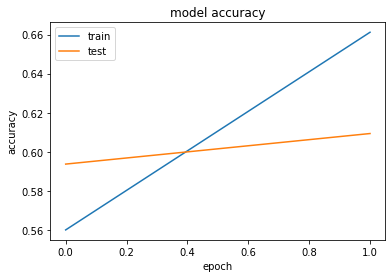

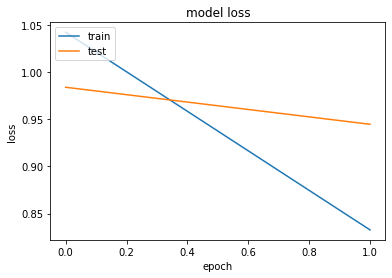

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
learner.view_top_losses(n=1, preproc=t)

----------
id:107 | loss:4.68 | true:0 | pred:3)



In [16]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [17]:
predictor.save('bert_B')

In [18]:
reloaded_predictor = ktrain.load_predictor('bert_B')

In [19]:
df_ans = pd.read_csv("preprocess_test_data.csv",index_col=0)
df_ans['text_clean'] = df_ans['text_clean'].fillna('neutral')
df_ans.head()

,_id,text,text_clean
0,60c5d6bf5659ea5e55deffcb,Fewer people coming in for vaccinations. So sa...,fewer peopl come vaccin sad nurs covidvaccin vumc
1,60c5d6bf5659ea5e55df028c,@MattHancock This may all be true. But... What...,may true piss big dom
2,60c5d6bf5659ea5e55def377,@Layla_EFC I’ve unfollowed him the wanker,unfollow wanker
3,60c5d6bf5659ea5e55def4c7,You guys are losing it all over the world. The...,guy lose world jung label islamophobia
4,60c5d6bf5659ea5e55df01a6,"And thus death laughs... It is sad merriment, ...",thus death laugh sad merriment still covid ind...


In [ ]:
label = []
i = 0
for tweet in df_ans['text_clean'].tolist():
    ans = reloaded_predictor.predict(tweet)
    i += 1
    print(i,len(tweet))
    if (ans == 0):
        label.append('HATE')
    elif (ans == 1):
        label.append('NONE')
    elif (ans == 2):
        label.append('OFFN')
    elif (ans == 3):
        label.append('PRFN')

In [ ]:
df_ans['label'] = pd.Series(label)
df_ans.head(20)

In [ ]:
df_ans = df_ans.drop(['text','text_clean'],axis=1)
df_ans = df_ans.reset_index()
df_ans = df_ans.drop(['index'],axis=1)
df_ans.head()

In [ ]:
df_ans.to_csv('BERT_B.csv',index=False)